# 최근접 이웃(K-Nearest Neighbor)

* 특별한 예측 모델 없이 가장 가까운 데이터 포인트를 기반으로 예측을 수행하는 방법
* 분류와 회귀 모두 지원

![k nearest neighbor](https://upload.wikimedia.org/wikipedia/commons/thumb/e/e7/KnnClassification.svg/220px-KnnClassification.svg.png)

In [1]:
import pandas as pd
import numpy as np
import multiprocessing
import matplotlib.pyplot as plt
plt.style.use(['seaborn-whitegrid'])

In [78]:
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.manifold import TSNE
from sklearn.datasets import load_iris, load_breast_cancer, load_wine
from sklearn.datasets import load_boston, fetch_california_housing
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline, Pipeline

## K 최근접 이웃 분류

* 입력 데이터 포인트와 가장 가까운 k개의 훈련 데이터 포인트가 출력
* k개의 데이터 포인트 중 가장 많은 클래스가 예측 결과

### 붓꽃 데이터

In [3]:
iris = load_iris()

In [4]:
iris_df = pd.DataFrame(data=iris.data, columns=iris.feature_names)
iris_df['Target'] = iris.target
iris_df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),Target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2
146,6.3,2.5,5.0,1.9,2
147,6.5,3.0,5.2,2.0,2
148,6.2,3.4,5.4,2.3,2


In [20]:
X, y = load_iris(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [21]:
scaler = StandardScaler()
X_train_scale = scaler.fit_transform(X_train)
X_test_scale = scaler.transform(X_test)


In [7]:
model = KNeighborsClassifier()
model.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [8]:
print("학습 데이터 점수: {}".format(model.score(X_train, y_train)))
print("평가 데이터 점수: {}".format(model.score(X_test, y_test)))

학습 데이터 점수: 0.975
평가 데이터 점수: 0.9666666666666667


In [9]:
model = KNeighborsClassifier()
model.fit(X_train_scale, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [10]:
print("학습 데이터 점수: {}".format(model.score(X_train_scale, y_train)))
print("평가 데이터 점수: {}".format(model.score(X_test, y_test)))

학습 데이터 점수: 0.975
평가 데이터 점수: 0.43333333333333335


In [11]:
cross_validate(
    estimator=KNeighborsClassifier(),
    X=X, y=y,
    cv=5,
    n_jobs = multiprocessing.cpu_count(),
    verbose=True
)

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:    1.1s finished


{'fit_time': array([0.00166845, 0.00109839, 0.00092173, 0.0007441 , 0.00073671]),
 'score_time': array([0.00326633, 0.0021131 , 0.00281882, 0.00282717, 0.00274539]),
 'test_score': array([0.96666667, 1.        , 0.93333333, 0.96666667, 1.        ])}

In [17]:
param_grid = [{'n_neighbors': [3,5,7],
               'weights': ['uniform', 'distance'],
               'algorithm':['ball_tree', 'kd_tree', 'brute']}]

In [23]:
gs = GridSearchCV(
    estimator = KNeighborsClassifier(),
    param_grid = param_grid,
    n_jobs = multiprocessing.cpu_count(),
    verbose=True
)

In [24]:
gs.fit(X, y)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  90 out of  90 | elapsed:    1.0s finished


GridSearchCV(cv=None, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=2,
             param_grid=[{'algorithm': ['ball_tree', 'kd_tree', 'brute'],
                          'n_neighbors': [3, 5, 7],
                          'weights': ['uniform', 'distance']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=True)

In [25]:
gs.best_estimator_

KNeighborsClassifier(algorithm='ball_tree', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=7, p=2,
                     weights='uniform')

In [26]:
print('GridSearchCv best Score: {}'.format(gs.best_score_))

GridSearchCv best Score: 0.9800000000000001


In [42]:
def make_meshgrid(x,y, h=.02):
  x_min, x_max = x.min()-1, x.max()+1
  y_min, y_max = y.min()-1, y.max()+1
  xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                       np.arange(y_min, y_max, h))
  
  return xx, yy

def plot_contours(clf, xx, yy, **params):
  Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
  Z = Z.reshape(xx.shape)
  out = plt.contourf(xx, yy, Z, **params)
  
  return out

In [34]:
tsne = TSNE(n_components=2)
X_comp = tsne.fit_transform(X)

In [35]:
iris_comp_df = pd.DataFrame(data=X_comp)
iris_comp_df['Target'] = y
iris_comp_df

,0,1,Target
0,27.012760,-9.151510,0
1,29.569338,-8.067592,0
2,29.745396,-9.252932,0
3,30.084826,-8.944842,0
4,27.109940,-9.336394,0
...,...,...,...
145,-10.461343,6.751492,2
146,-13.295705,5.241616,2
147,-11.277614,6.340624,2
148,-9.983919,7.594049,2


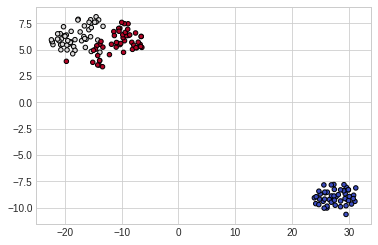

In [36]:
plt.scatter(X_comp[:, 0], X_comp[:, 1], c=y, cmap=plt.cm.coolwarm, s=20, edgecolor='k')

In [39]:
model = KNeighborsClassifier()
model.fit(X_comp, y)
predict = model.predict(X_comp)

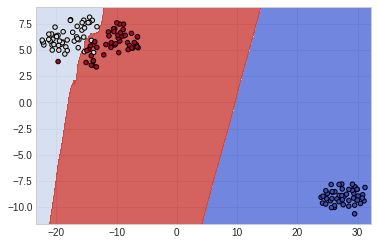

In [43]:
xx, yy = make_meshgrid(X_comp[:, 0], X_comp[:, 1])
plot_contours(model, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
plt.scatter(X_comp[:, 0], X_comp[:, 1], c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k');

### 유방암 데이터

In [44]:
cancer = load_breast_cancer()

In [45]:
cancer_df = pd.DataFrame(data=cancer.data, columns=cancer.feature_names)
cancer_df['target'] = cancer.target
cancer_df

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,1.1760,1.2560,7.673,158.70,0.010300,0.02891,0.05198,0.02454,0.01114,0.004239,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115,0
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,0.7655,2.4630,5.203,99.04,0.005769,0.02423,0.03950,0.01678,0.01898,0.002498,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637,0
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,0.4564,1.0750,3.425,48.55,0.005903,0.03731,0.04730,0.01557,0.01318,0.003892,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820,0
567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,0.7260,1.5950,5.772,86.22,0.006522,0.06158,0.07117,0.01664,0.02324,0.006185,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400,0


In [46]:
X, y = cancer.data, cancer.target
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)

In [48]:
cancer_train_df = pd.DataFrame(data=X_train, columns=cancer.feature_names)
cancer_train_df['target'] = y_train
cancer_train_df

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,13.69,16.07,87.84,579.1,0.08302,0.06374,0.02556,0.02031,0.1872,0.05669,0.1705,0.5066,1.372,14.00,0.004230,0.01587,0.011690,0.006335,0.01943,0.002177,14.84,20.21,99.16,670.6,0.1105,0.20960,0.13460,0.06987,0.3323,0.07701,1
1,12.16,18.03,78.29,455.3,0.09087,0.07838,0.02916,0.01527,0.1464,0.06284,0.2194,1.1900,1.678,16.26,0.004911,0.01666,0.013970,0.005161,0.01454,0.001858,13.34,27.87,88.83,547.4,0.1208,0.22790,0.16200,0.05690,0.2406,0.07729,1
2,12.72,13.78,81.78,492.1,0.09667,0.08393,0.01288,0.01924,0.1638,0.06100,0.1807,0.6931,1.340,13.38,0.006064,0.01180,0.006564,0.007978,0.01374,0.001392,13.50,17.48,88.54,553.7,0.1298,0.14720,0.05233,0.06343,0.2369,0.06922,1
3,11.60,18.36,73.88,412.7,0.08508,0.05855,0.03367,0.01777,0.1516,0.05859,0.1816,0.7656,1.303,12.89,0.006709,0.01701,0.020800,0.007497,0.02124,0.002768,12.77,24.02,82.68,495.1,0.1342,0.18080,0.18600,0.08288,0.3210,0.07863,1
4,19.02,24.59,122.00,1076.0,0.09029,0.12060,0.14680,0.08271,0.1953,0.05629,0.5495,0.6636,3.055,57.65,0.003872,0.01842,0.037100,0.012000,0.01964,0.003337,24.56,30.41,152.90,1623.0,0.1249,0.32060,0.57550,0.19560,0.3956,0.09288,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
450,15.34,14.26,102.50,704.4,0.10730,0.21350,0.20770,0.09756,0.2521,0.07032,0.4388,0.7096,3.384,44.91,0.006789,0.05328,0.064460,0.022520,0.03672,0.004394,18.07,19.08,125.10,980.9,0.1390,0.59540,0.63050,0.23930,0.4667,0.09946,0
451,12.76,13.37,82.29,504.1,0.08794,0.07948,0.04052,0.02548,0.1601,0.06140,0.3265,0.6594,2.346,25.18,0.006494,0.02768,0.031370,0.010690,0.01731,0.004392,14.19,16.40,92.04,618.8,0.1194,0.22080,0.17690,0.08411,0.2564,0.08253,1
452,11.89,21.17,76.39,433.8,0.09773,0.08120,0.02555,0.02179,0.2019,0.06290,0.2747,1.2030,1.930,19.53,0.009895,0.03053,0.016300,0.009276,0.02258,0.002272,13.05,27.21,85.09,522.9,0.1426,0.21870,0.11640,0.08263,0.3075,0.07351,1
453,11.27,15.50,73.38,392.0,0.08365,0.11140,0.10070,0.02757,0.1810,0.07252,0.3305,1.0670,2.569,22.97,0.010380,0.06669,0.094720,0.020470,0.01219,0.012330,12.04,18.93,79.73,450.0,0.1102,0.28090,0.30210,0.08272,0.2157,0.10430,1


In [49]:
cancer_test_df = pd.DataFrame(data=X_test, columns=cancer.feature_names)
cancer_test_df['target'] = y_test
cancer_test_df

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,11.43,15.39,73.06,399.8,0.09639,0.06889,0.03503,0.02875,0.1734,0.05865,0.1759,0.9938,1.143,12.67,0.005133,0.01521,0.014340,0.008602,0.01501,0.001588,12.32,22.02,79.93,462.0,0.1190,0.1648,0.13990,0.08476,0.2676,0.06765,1
1,11.95,14.96,77.23,426.7,0.11580,0.12060,0.01171,0.01787,0.2459,0.06581,0.3610,1.0500,2.455,26.65,0.005800,0.02417,0.007816,0.010520,0.02734,0.003114,12.81,17.72,83.09,496.2,0.1293,0.1885,0.03122,0.04766,0.3124,0.07590,1
2,14.54,27.54,96.73,658.8,0.11390,0.15950,0.16390,0.07364,0.2303,0.07077,0.3700,1.0330,2.879,32.55,0.005607,0.04240,0.047410,0.010900,0.01857,0.005466,17.46,37.13,124.10,943.2,0.1678,0.6577,0.70260,0.17120,0.4218,0.13410,0
3,17.68,20.74,117.40,963.7,0.11150,0.16650,0.18550,0.10540,0.1971,0.06166,0.8113,1.4000,5.540,93.91,0.009037,0.04954,0.052060,0.018410,0.01778,0.004968,20.47,25.11,132.90,1302.0,0.1418,0.3498,0.35830,0.15150,0.2463,0.07738,0
4,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,0.7260,1.5950,5.772,86.22,0.006522,0.06158,0.071170,0.016640,0.02324,0.006185,25.74,39.42,184.60,1821.0,0.1650,0.8681,0.93870,0.26500,0.4087,0.12400,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109,23.29,26.67,158.90,1685.0,0.11410,0.20840,0.35230,0.16200,0.2200,0.06229,0.5539,1.5600,4.667,83.16,0.009327,0.05121,0.089580,0.024650,0.02175,0.005195,25.12,32.68,177.00,1986.0,0.1536,0.4167,0.78920,0.27330,0.3198,0.08762,0
110,11.26,19.96,73.72,394.1,0.08020,0.11810,0.09274,0.05588,0.2595,0.06233,0.4866,1.9050,2.877,34.68,0.015740,0.08262,0.080990,0.034870,0.03418,0.006517,11.86,22.33,78.27,437.6,0.1028,0.1843,0.15460,0.09314,0.2955,0.07009,1
111,11.30,18.19,73.93,389.4,0.09592,0.13250,0.15480,0.02854,0.2054,0.07669,0.2428,1.6420,2.369,16.39,0.006663,0.05914,0.088800,0.013140,0.01995,0.008675,12.58,27.96,87.16,472.9,0.1347,0.4848,0.74360,0.12180,0.3308,0.12970,1
112,19.53,18.90,129.50,1217.0,0.11500,0.16420,0.21970,0.10620,0.1792,0.06552,1.1110,1.1610,7.237,133.00,0.006056,0.03203,0.056380,0.017330,0.01884,0.004787,25.93,26.24,171.10,2053.0,0.1495,0.4116,0.61210,0.19800,0.2968,0.09929,0


In [53]:
scaler = StandardScaler()
X_train_scale = scaler.fit_transform(X_train)
X_test_scale = scaler.transform(X_test)

In [54]:
model = KNeighborsClassifier()
model.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [55]:
print("학습 데이터 점수: {}".format(model.score(X_train, y_train)))
print("평가 데이터 점수: {}".format(model.score(X_test, y_test)))

학습 데이터 점수: 0.9582417582417583
평가 데이터 점수: 0.9122807017543859


In [57]:
model = KNeighborsClassifier()
model.fit(X_train_scale, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [58]:
print("학습 데이터 점수: {}".format(model.score(X_train_scale, y_train)))
print("평가 데이터 점수: {}".format(model.score(X_test_scale, y_test)))

학습 데이터 점수: 0.9758241758241758
평가 데이터 점수: 0.956140350877193


In [59]:
estimator = make_pipeline(
    StandardScaler(),
    KNeighborsClassifier()
)

In [60]:
cross_validate(
    estimator = estimator,
    X=X, y=y,
    cv=5,
    n_jobs = multiprocessing.cpu_count(),
    verbose = True
)

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:    0.9s finished


{'fit_time': array([0.00448656, 0.00448895, 0.00539851, 0.00326467, 0.00208354]),
 'score_time': array([0.01204681, 0.01216555, 0.01189756, 0.01188111, 0.00625682]),
 'test_score': array([0.96491228, 0.95614035, 0.98245614, 0.95614035, 0.96460177])}

In [61]:
pipe = Pipeline(
    [('scaler', StandardScaler()),
     ('model', KNeighborsClassifier())]
)

In [67]:
param_grid = [{'model__n_neighbors': [3, 5, 7],
               'model__weights': ['uniform', 'distance'],
               'model__algorithm': ['ball_tree', 'kd_tree', 'brute']}]

In [68]:
gs = GridSearchCV(
    estimator = pipe,
    param_grid = param_grid,
    n_jobs = multiprocessing.cpu_count(),
    verbose = True
)

In [69]:
gs.fit(X, y)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  90 out of  90 | elapsed:    1.5s finished


GridSearchCV(cv=None, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('model',
                                        KNeighborsClassifier(algorithm='auto',
                                                             leaf_size=30,
                                                             metric='minkowski',
                                                             metric_params=None,
                                                             n_jobs=None,
                                                             n_neighbors=5, p=2,
                                                             weights='uniform'))],
                                verbose=False),
      

In [71]:
print('GridSearchCV best score: {}'.format(gs.best_score_))

GridSearchCV best score: 0.9701288619779538


In [72]:
tsne = TSNE(n_components=2)
X_comp = tsne.fit_transform(X)

In [99]:
cancer_comp_df = pd.DataFrame(data=X_comp)
cancer_comp_df['target'] = y
cancer_comp_df

,0,1,target
0,-7.727134,6.472120,0
1,-7.004320,6.798843,0
2,-9.199368,8.134038,0
3,-11.314115,10.057913,0
4,-0.903030,1.166557,0
...,...,...,...
173,-0.619383,1.508736,2
174,-0.987537,1.738293,2
175,-3.215760,3.166380,2
176,-3.408003,3.206700,2


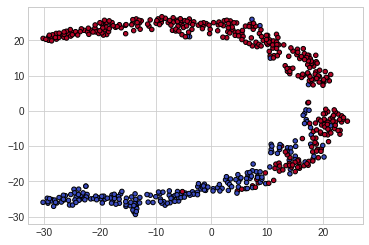

In [74]:
plt.scatter(X_comp[:,0], X_comp[:,1], c=y, cmap=plt.cm.coolwarm, s=20, edgecolor='k')

In [75]:
model = KNeighborsClassifier()
model.fit(X_comp, y)
predict = model.predict(X_comp)

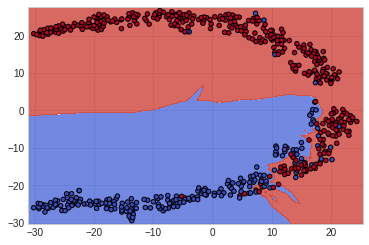

In [77]:
xx, yy = make_meshgrid(X_comp[:,0], X_comp[:,1])
plot_contours(model, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
plt.scatter(X_comp[:,0], X_comp[:,1], c=y, cmap=plt.cm.coolwarm, s=20, edgecolor='k')

### 와인 데이터

In [80]:
wine = load_wine()

In [81]:
wine_df = pd.DataFrame(data=wine.data, columns=wine.feature_names)
wine_df['target'] = wine.target
wine_df

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,13.71,5.65,2.45,20.5,95.0,1.68,0.61,0.52,1.06,7.70,0.64,1.74,740.0,2
174,13.40,3.91,2.48,23.0,102.0,1.80,0.75,0.43,1.41,7.30,0.70,1.56,750.0,2
175,13.27,4.28,2.26,20.0,120.0,1.59,0.69,0.43,1.35,10.20,0.59,1.56,835.0,2
176,13.17,2.59,2.37,20.0,120.0,1.65,0.68,0.53,1.46,9.30,0.60,1.62,840.0,2


In [82]:
X, y = wine.data, wine.target
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)

In [83]:
wine_train_df = pd.DataFrame(data=X_train, columns=wine.feature_names)
wine_train_df['target'] = y_train
wine_train_df

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
0,12.29,1.41,1.98,16.0,85.0,2.55,2.50,0.29,1.77,2.90,1.23,2.74,428.0,1
1,12.82,3.37,2.30,19.5,88.0,1.48,0.66,0.40,0.97,10.26,0.72,1.75,685.0,2
2,13.07,1.50,2.10,15.5,98.0,2.40,2.64,0.28,1.37,3.70,1.18,2.69,1020.0,0
3,11.66,1.88,1.92,16.0,97.0,1.61,1.57,0.34,1.15,3.80,1.23,2.14,428.0,1
4,12.99,1.67,2.60,30.0,139.0,3.30,2.89,0.21,1.96,3.35,1.31,3.50,985.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137,12.00,0.92,2.00,19.0,86.0,2.42,2.26,0.30,1.43,2.50,1.38,3.12,278.0,1
138,14.20,1.76,2.45,15.2,112.0,3.27,3.39,0.34,1.97,6.75,1.05,2.85,1450.0,0
139,13.48,1.67,2.64,22.5,89.0,2.60,1.10,0.52,2.29,11.75,0.57,1.78,620.0,2
140,13.05,1.73,2.04,12.4,92.0,2.72,3.27,0.17,2.91,7.20,1.12,2.91,1150.0,0


In [84]:
wine_test_df = pd.DataFrame(data=X_test, columns=wine.feature_names)
wine_test_df['target'] = y_test
wine_test_df

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
0,12.08,1.39,2.50,22.5,84.0,2.56,2.29,0.43,1.04,2.90,0.93,3.19,385.0,1
1,13.16,3.57,2.15,21.0,102.0,1.50,0.55,0.43,1.30,4.00,0.60,1.68,830.0,2
2,12.22,1.29,1.94,19.0,92.0,2.36,2.04,0.39,2.08,2.70,0.86,3.02,312.0,1
3,14.30,1.92,2.72,20.0,120.0,2.80,3.14,0.33,1.97,6.20,1.07,2.65,1280.0,0
4,12.17,1.45,2.53,19.0,104.0,1.89,1.75,0.45,1.03,2.95,1.45,2.23,355.0,1
5,12.08,1.83,2.32,18.5,81.0,1.60,1.50,0.52,1.64,2.40,1.08,2.27,480.0,1
6,11.64,2.06,2.46,21.6,84.0,1.95,1.69,0.48,1.35,2.80,1.00,2.75,680.0,1
7,12.52,2.43,2.17,21.0,88.0,2.55,2.27,0.26,1.22,2.00,0.90,2.78,325.0,1
8,13.74,1.67,2.25,16.4,118.0,2.60,2.90,0.21,1.62,5.85,0.92,3.20,1060.0,0
9,13.48,1.81,2.41,20.5,100.0,2.70,2.98,0.26,1.86,5.10,1.04,3.47,920.0,0


In [85]:
scaler = StandardScaler()
X_train_scale = scaler.fit_transform(X_train)
X_test_scale = scaler.transform(X_test)

In [86]:
model = KNeighborsClassifier()
model.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [87]:
print("학습 데이터 점수: {}".format(model.score(X_train, y_train)))
print("평가 데이터 점수: {}".format(model.score(X_test, y_test)))

학습 데이터 점수: 0.795774647887324
평가 데이터 점수: 0.7222222222222222


In [88]:
model = KNeighborsClassifier()
model.fit(X_train_scale, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [89]:
print("학습 데이터 점수: {}".format(model.score(X_train_scale, y_train)))
print("평가 데이터 점수: {}".format(model.score(X_test_scale, y_test)))

학습 데이터 점수: 0.9647887323943662
평가 데이터 점수: 1.0


In [90]:
estimator = make_pipeline(
    StandardScaler(),
    KNeighborsClassifier()
)

In [91]:
cross_validate(
    estimator = estimator,
    X=X, y=y,
    cv=5,
    n_jobs = multiprocessing.cpu_count(),
    verbose = True
)

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:    1.0s finished


{'fit_time': array([0.00320458, 0.00324726, 0.00215149, 0.00202179, 0.00124907]),
 'score_time': array([0.00390816, 0.00389361, 0.00362158, 0.0035634 , 0.00203776]),
 'test_score': array([0.94444444, 0.94444444, 0.97222222, 1.        , 0.88571429])}

In [92]:
pipe = Pipeline(
    [('scaler', StandardScaler()),
     ('model', KNeighborsClassifier())]
)

In [93]:
param_grid = [{'model__n_neighbors': [3, 5, 7],
               'model__weights': ['uniform', 'distance'],
               'model__algorithm': ['ball_tree', 'kd_tree', 'brute']}]

In [94]:
gs = GridSearchCV(
    estimator = pipe,
    param_grid = param_grid,
    n_jobs = multiprocessing.cpu_count(),
    verbose = True
)

In [95]:
gs.fit(X, y)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  90 out of  90 | elapsed:    0.3s finished


GridSearchCV(cv=None, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('model',
                                        KNeighborsClassifier(algorithm='auto',
                                                             leaf_size=30,
                                                             metric='minkowski',
                                                             metric_params=None,
                                                             n_jobs=None,
                                                             n_neighbors=5, p=2,
                                                             weights='uniform'))],
                                verbose=False),
      

In [96]:
print('GridSearchCV best score: {}'.format(gs.best_score_))

GridSearchCV best score: 0.9665079365079364


In [97]:
tsne = TSNE(n_components=2)
X_comp = tsne.fit_transform(X)

In [100]:
wine_comp_df = pd.DataFrame(data=X_comp)
wine_comp_df['target'] = y
wine_comp_df

,0,1,target
0,-7.727134,6.472120,0
1,-7.004320,6.798843,0
2,-9.199368,8.134038,0
3,-11.314115,10.057913,0
4,-0.903030,1.166557,0
...,...,...,...
173,-0.619383,1.508736,2
174,-0.987537,1.738293,2
175,-3.215760,3.166380,2
176,-3.408003,3.206700,2


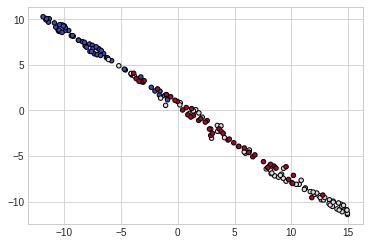

In [101]:
plt.scatter(X_comp[:,0], X_comp[:,1], c=y, cmap=plt.cm.coolwarm, s=20, edgecolor='k')

In [102]:
model = KNeighborsClassifier()
model.fit(X_comp, y)
predict = model.predict(X_comp)

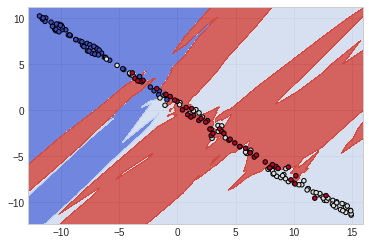

In [103]:
xx, yy = make_meshgrid(X_comp[:,0], X_comp[:,1])
plot_contours(model, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
plt.scatter(X_comp[:,0], X_comp[:,1], c=y, cmap=plt.cm.coolwarm, s=20, edgecolor='k')

## k 최근접 이웃 회귀

* k 최근접 이웃 분류와 마찬가지로 예측에 이웃 데이터 포인트 사용
* 이웃 데이터 포인트의 평균이 예측 결과

### 보스턴 주택 가격 데이터

In [104]:
boston = load_boston()

In [105]:
boston_df = pd.DataFrame(data=boston.data, columns=boston.feature_names)
boston_df['TARGET'] = boston.target
boston_df

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,TARGET
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0.0,0.573,6.593,69.1,2.4786,1.0,273.0,21.0,391.99,9.67,22.4
502,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1.0,273.0,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0.0,0.573,6.976,91.0,2.1675,1.0,273.0,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0.0,0.573,6.794,89.3,2.3889,1.0,273.0,21.0,393.45,6.48,22.0


In [106]:
X, y = boston.data, boston.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [107]:
boston_train_df = pd.DataFrame(data=X_train, columns=boston.feature_names)
boston_train_df['TARGET'] = y_train
boston_train_df

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,TARGET
0,0.04301,80.0,1.91,0.0,0.413,5.663,21.9,10.5857,4.0,334.0,22.0,382.80,8.05,18.2
1,0.24980,0.0,21.89,0.0,0.624,5.857,98.2,1.6686,4.0,437.0,21.2,392.04,21.32,13.3
2,5.66998,0.0,18.10,1.0,0.631,6.683,96.8,1.3567,24.0,666.0,20.2,375.33,3.73,50.0
3,0.33045,0.0,6.20,0.0,0.507,6.086,61.5,3.6519,8.0,307.0,17.4,376.75,10.88,24.0
4,0.35233,0.0,21.89,0.0,0.624,6.454,98.4,1.8498,4.0,437.0,21.2,394.08,14.59,17.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
399,0.82526,20.0,3.97,0.0,0.647,7.327,94.5,2.0788,5.0,264.0,13.0,393.42,11.25,31.0
400,0.46296,0.0,6.20,0.0,0.504,7.412,76.9,3.6715,8.0,307.0,17.4,376.14,5.25,31.7
401,0.07244,60.0,1.69,0.0,0.411,5.884,18.5,10.7103,4.0,411.0,18.3,392.33,7.79,18.6
402,0.02177,82.5,2.03,0.0,0.415,7.610,15.7,6.2700,2.0,348.0,14.7,395.38,3.11,42.3


In [108]:
boston_test_df = pd.DataFrame(data=X_test, columns=boston.feature_names)
boston_test_df['TARGET'] = y_test
boston_test_df

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,TARGET
0,0.33983,22.0,5.86,0.0,0.431,6.108,34.9,8.0555,7.0,330.0,19.1,390.18,9.16,24.3
1,2.14918,0.0,19.58,0.0,0.871,5.709,98.5,1.6232,5.0,403.0,14.7,261.95,15.79,19.4
2,0.15876,0.0,10.81,0.0,0.413,5.961,17.5,5.2873,4.0,305.0,19.2,376.94,9.88,21.7
3,0.15445,25.0,5.13,0.0,0.453,6.145,29.2,7.8148,8.0,284.0,19.7,390.68,6.86,23.3
4,0.65665,20.0,3.97,0.0,0.647,6.842,100.0,2.0107,5.0,264.0,13.0,391.93,6.90,30.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97,7.36711,0.0,18.10,0.0,0.679,6.193,78.1,1.9356,24.0,666.0,20.2,96.73,21.52,11.0
98,4.34879,0.0,18.10,0.0,0.580,6.167,84.0,3.0334,24.0,666.0,20.2,396.90,16.29,19.9
99,0.44178,0.0,6.20,0.0,0.504,6.552,21.4,3.3751,8.0,307.0,17.4,380.34,3.76,31.5
100,0.54050,20.0,3.97,0.0,0.575,7.470,52.6,2.8720,5.0,264.0,13.0,390.30,3.16,43.5


In [109]:
scaler = StandardScaler()
X_train_scale = scaler.fit_transform(X_train)
X_test_scale = scaler.transform(X_test)

In [110]:
model = KNeighborsRegressor()
model.fit(X_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                    weights='uniform')

In [111]:
print("학습 데이터 점수: {}".format(model.score(X_train, y_train)))
print("평가 데이터 점수: {}".format(model.score(X_test, y_test)))

학습 데이터 점수: 0.702558998135788
평가 데이터 점수: 0.4846480389533296


In [113]:
model = KNeighborsRegressor()
model.fit(X_train_scale, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                    weights='uniform')

In [115]:
print("학습 데이터 점수: {}".format(model.score(X_train_scale, y_train)))
print("평가 데이터 점수: {}".format(model.score(X_test_scale, y_test)))

학습 데이터 점수: 0.8457259710035759
평가 데이터 점수: 0.7369189309440405


In [116]:
estimator = make_pipeline(
    StandardScaler(),
    KNeighborsRegressor()
)

In [117]:
cross_validate(
    estimator = estimator,
    X=X, y=y,
    cv=5,
    n_jobs = multiprocessing.cpu_count(),
    verbose = True
)

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:    1.0s finished


{'fit_time': array([0.00337672, 0.00319743, 0.00257492, 0.00179219, 0.00190091]),
 'score_time': array([0.00368714, 0.00316834, 0.00263619, 0.00258923, 0.00238872]),
 'test_score': array([0.56089547, 0.61917359, 0.48661916, 0.46986886, 0.23133037])}

In [118]:
pipe = Pipeline(
    [('scaler', StandardScaler()),
     ('model', KNeighborsRegressor())]
)

In [119]:
param_grid = [{'model__n_neighbors': [3, 5, 7],
               'model__weights': ['uniform', 'distance'],
               'model__algorithm': ['ball_tree', 'kd_tree', 'brute']}]

In [120]:
gs = GridSearchCV(
    estimator = pipe,
    param_grid = param_grid,
    n_jobs = multiprocessing.cpu_count(),
    verbose = True
)

In [121]:
gs.fit(X, y)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  90 out of  90 | elapsed:    0.4s finished


GridSearchCV(cv=None, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('model',
                                        KNeighborsRegressor(algorithm='auto',
                                                            leaf_size=30,
                                                            metric='minkowski',
                                                            metric_params=None,
                                                            n_jobs=None,
                                                            n_neighbors=5, p=2,
                                                            weights='uniform'))],
                                verbose=False),
             

In [122]:
print('GridSearchCV best score: {}'.format(gs.best_score_))

GridSearchCV best score: 0.4973060611762845


In [129]:
tsne = TSNE(n_components=1)
X_comp = tsne.fit_transform(X)

In [130]:
boston_comp_df = pd.DataFrame(data=X_comp)
boston_comp_df['target'] = y
boston_comp_df

,0,target
0,-23.082153,24.0
1,-44.938351,21.6
2,-41.182095,34.7
3,-42.150112,33.4
4,-42.415985,36.2
...,...,...
501,-26.272968,22.4
502,-26.955288,20.6
503,-27.750565,23.9
504,-27.709000,22.0


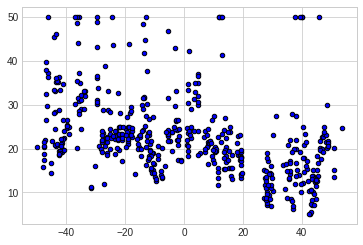

In [136]:
plt.scatter(X_comp, y, c='b', cmap=plt.cm.coolwarm, s=20, edgecolor='k')

In [137]:
model = KNeighborsRegressor()
model.fit(X_comp, y)
predict = model.predict(X_comp)

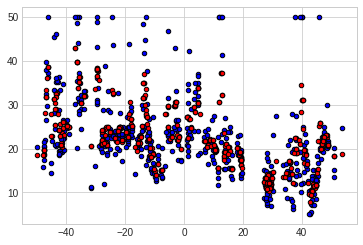

In [138]:
plt.scatter(X_comp, y, c='b', cmap=plt.cm.coolwarm, s=20, edgecolor='k')
plt.scatter(X_comp, predict, c='r', cmap=plt.cm.coolwarm, s=20, edgecolor='k')

### 캘리포니아 주택 가격 데이터

In [139]:
california = fetch_california_housing()

In [141]:
california_df = pd.DataFrame(data=california.data, columns=california.feature_names)
california_df['TARGET'] = california.target
california_df

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,TARGET
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422
...,...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09,0.781
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21,0.771
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22,0.923
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32,0.847


In [142]:
X, y = california.data, california.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [143]:
california_train_df = pd.DataFrame(data=X_train, columns=california.feature_names)
california_train_df['TARGET'] = y_train
california_train_df

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,TARGET
0,3.8710,27.0,5.404301,1.026882,3899.0,4.192473,34.02,-117.94,1.629
1,4.1053,5.0,5.113281,1.052734,1320.0,2.578125,33.14,-117.13,1.714
2,3.0927,40.0,4.818182,1.012987,584.0,2.528139,33.98,-118.36,3.160
3,3.0000,52.0,3.960417,1.093750,1856.0,3.866667,34.11,-118.20,1.564
4,4.5662,33.0,5.746835,1.028481,768.0,2.430380,32.80,-117.00,1.503
...,...,...,...,...,...,...,...,...,...
16507,4.4097,34.0,6.378882,1.031056,1659.0,2.576087,32.78,-117.19,2.520
16508,2.2000,49.0,5.187500,1.097222,611.0,2.121528,37.74,-122.15,1.875
16509,5.3146,33.0,5.201183,1.071006,547.0,3.236686,33.92,-118.09,1.686
16510,1.5078,22.0,3.966844,1.049072,2486.0,3.297082,34.04,-118.16,1.819


In [144]:
california_test_df = pd.DataFrame(data=X_test, columns=california.feature_names)
california_test_df['TARGET'] = y_test
california_test_df

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,TARGET
0,5.1099,26.0,5.766409,1.040541,1931.0,3.727799,37.37,-121.81,2.13100
1,4.1116,45.0,4.108187,0.988304,733.0,2.143275,37.72,-122.48,1.87500
2,6.5160,32.0,7.515152,1.012987,602.0,2.606061,37.92,-122.29,4.01000
3,3.5446,19.0,6.804574,1.270270,1164.0,2.419958,37.39,-119.59,1.06500
4,15.0001,36.0,9.368263,1.173653,862.0,2.580838,34.09,-118.44,5.00001
...,...,...,...,...,...,...,...,...,...
4123,1.6023,35.0,6.323529,1.323529,100.0,2.941176,37.95,-122.37,0.81300
4124,4.7543,27.0,5.356800,1.112000,1545.0,2.472000,33.87,-118.31,2.96300
4125,2.5809,52.0,4.700280,1.081232,1220.0,3.417367,37.75,-122.41,2.55300
4126,3.4919,44.0,5.138418,1.031073,1137.0,3.211864,37.75,-122.50,2.71800


In [145]:
scaler = StandardScaler()
X_train_scale = scaler.fit_transform(X_train)
X_test_scale = scaler.transform(X_test)

In [146]:
model = KNeighborsRegressor()
model.fit(X_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                    weights='uniform')

In [147]:
print("학습 데이터 점수: {}".format(model.score(X_train, y_train)))
print("평가 데이터 점수: {}".format(model.score(X_test, y_test)))

학습 데이터 점수: 0.45857351411488034
평가 데이터 점수: 0.14426199129177653


In [148]:
model = KNeighborsRegressor()
model.fit(X_train_scale, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                    weights='uniform')

In [149]:
print("학습 데이터 점수: {}".format(model.score(X_train_scale, y_train)))
print("평가 데이터 점수: {}".format(model.score(X_test_scale, y_test)))

학습 데이터 점수: 0.8205491768156593
평가 데이터 점수: 0.6925885200446695


In [150]:
estimator = make_pipeline(
    StandardScaler(),
    KNeighborsRegressor()
)

In [151]:
cross_validate(
    estimator = estimator,
    X=X, y=y,
    cv=5,
    n_jobs = multiprocessing.cpu_count(),
    verbose = True
)

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:    2.5s finished


{'fit_time': array([0.03996849, 0.04704762, 0.03467846, 0.0380075 , 0.03720737]),
 'score_time': array([0.5470531 , 0.47148418, 0.501091  , 0.58312249, 0.39423108]),
 'test_score': array([0.47879396, 0.4760079 , 0.57624554, 0.50259828, 0.57228584])}

In [152]:
pipe = Pipeline(
    [('scaler', StandardScaler()),
     ('model', KNeighborsRegressor())]
)

In [153]:
param_grid = [{'model__n_neighbors': [3, 5, 7],
               'model__weights': ['uniform', 'distance'],
               'model__algorithm': ['ball_tree', 'kd_tree', 'brute']}]

In [154]:
gs = GridSearchCV(
    estimator = pipe,
    param_grid = param_grid,
    n_jobs = multiprocessing.cpu_count(),
    verbose = True
)

In [155]:
gs.fit(X, y)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   22.9s
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=2)]: Done  90 out of  90 | elapsed:  1.0min finished


GridSearchCV(cv=None, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('model',
                                        KNeighborsRegressor(algorithm='auto',
                                                            leaf_size=30,
                                                            metric='minkowski',
                                                            metric_params=None,
                                                            n_jobs=None,
                                                            n_neighbors=5, p=2,
                                                            weights='uniform'))],
                                verbose=False),
             

In [156]:
print('GridSearchCV best score: {}'.format(gs.best_score_))

GridSearchCV best score: 0.5376515274379832


In [157]:
tsne = TSNE(n_components=1)
X_comp = tsne.fit_transform(X)

In [158]:
california_comp_df = pd.DataFrame(data=X_comp)
california_comp_df['target'] = y
california_comp_df

,0,target
0,-30.941092,4.526
1,-49.551968,3.585
2,-14.944584,3.521
3,9.862451,3.413
4,10.219323,3.422
...,...,...
20635,44.359432,0.781
20636,-29.600727,0.771
20637,-7.028068,0.923
20638,85.621895,0.847


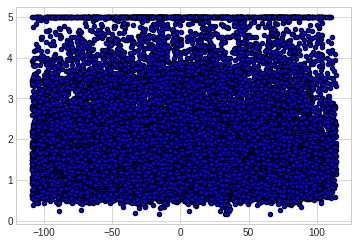

In [159]:
plt.scatter(X_comp, y, c='b', cmap=plt.cm.coolwarm, s=20, edgecolor='k')

In [160]:
model = KNeighborsRegressor()
model.fit(X_comp, y)
predict = model.predict(X_comp)

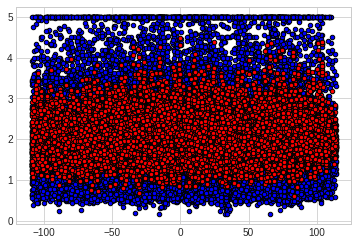

In [161]:
plt.scatter(X_comp, y, c='b', cmap=plt.cm.coolwarm, s=20, edgecolor='k')
plt.scatter(X_comp, predict, c='r', cmap=plt.cm.coolwarm, s=20, edgecolor='k')